In [48]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.tri as tri

In [3]:
# Load the Excel file
q_sheet = pd.read_excel("Excel med PLAXIS.xlsx", sheet_name="q")  
head_sheet= pd.read_excel("Excel med PLAXIS.xlsx", sheet_name="Head")  

In [7]:
# Check the data
# print(q_sheet.head())
print(head_sheet.head())

         Soil element  Stress point  Local number                  X [m]  \
0  Clus. 2 - El. 7822         93863            11              28.757082   
1    Drained material         93859             7              29.018216   
2          Soil\_1\_1         93853             1              28.996749   
3                             93860             8              29.041064   
4                             93862            10              28.775101   

                    Y [m]         p_water [kN/m²]        p_active [kN/m²]  \
0              -11.627743             -223.197898             -223.197898   
1              -11.601829             -221.486658             -221.486658   
2              -11.714284             -222.730054             -222.730054   
3              -11.451412             -219.856388             -219.856388   
4              -11.509121             -221.912458             -221.912458   

                Head [m]       p_excess [kN/m²]        p_steady [kN/m²]  \
0    

In [12]:
print(head_sheet.columns)

Index(['      Soil element', 'Stress point', 'Local number',
       '                X [m]', '                 Y [m]',
       '       p_water [kN/m²]', '      p_active [kN/m²]',
       '             Head [m]', '     p_excess [kN/m²]',
       '      p_steady [kN/m²]', '      Suction [kN/m²]',
       '  Suction_eff [kN/m²]', '                  R_u', 'Unnamed: 13',
       '                X [m].1', '                 Y [m].1',
       '             Head [m].1'],
      dtype='object')


In [13]:
# Remove any leading/trailing spaces in column names
head_sheet.columns = head_sheet.columns.str.strip()

In [14]:
print(head_sheet.columns)

Index(['Soil element', 'Stress point', 'Local number', 'X [m]', 'Y [m]',
       'p_water [kN/m²]', 'p_active [kN/m²]', 'Head [m]', 'p_excess [kN/m²]',
       'p_steady [kN/m²]', 'Suction [kN/m²]', 'Suction_eff [kN/m²]', 'R_u',
       'Unnamed: 13', 'X [m].1', 'Y [m].1', 'Head [m].1'],
      dtype='object')


In [20]:
# Plotting the head in the domain X,Y
x = head_sheet["X [m]"].values
y = head_sheet["Y [m]"].values
head = head_sheet["Head [m]"].values

In [30]:
# Define grid for interpolation
head.size

92208

In [22]:
print("Head min:", head.min(), "Head max:", head.max())

Head min: 9.78176043437903e-06 Head max: 19.9999902190223


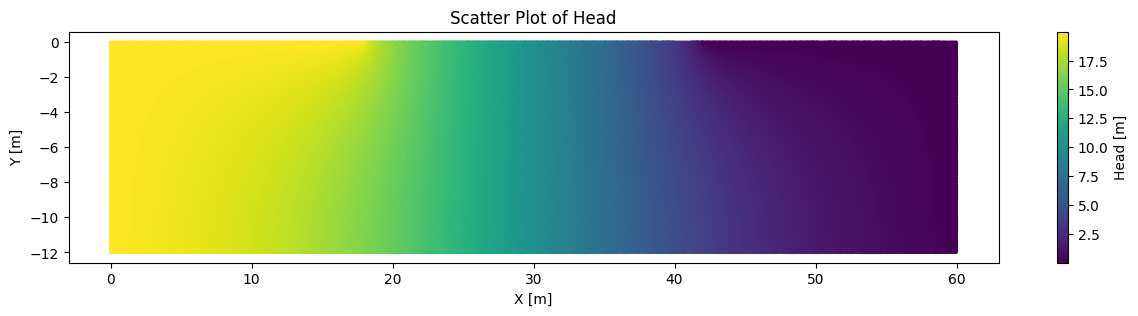

In [54]:
plt.figure(figsize=(15, 3))
plt.scatter(x, y, c=head, cmap="viridis", marker='o', s=3)
plt.colorbar(label="Head [m]")
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.title("Scatter Plot of Head")
plt.show()

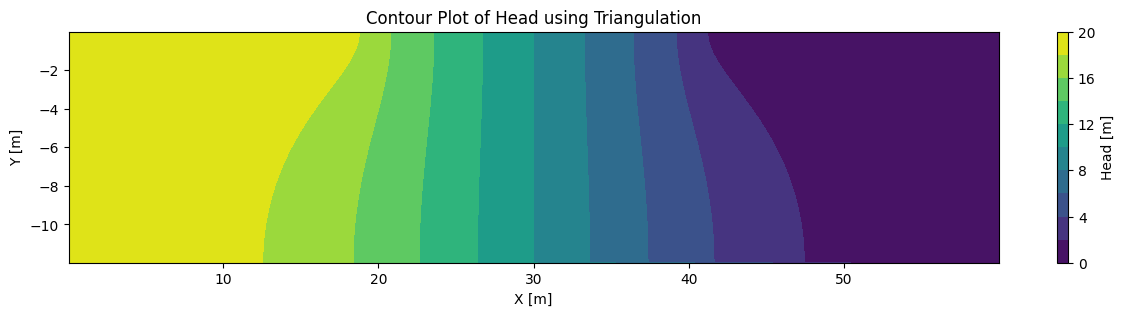

In [53]:
# Create a triangulation object
triang = tri.Triangulation(x, y)

# Plot contour
plt.figure(figsize=(15, 3))
plt.tricontourf(triang, head, levels=10, cmap="viridis")
plt.colorbar(label="Head [m]")
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.title("Contour Plot of Head using Triangulation")
plt.show()
